In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from czifile import imread
from roifile import ImagejRoi
from skimage import draw, measure
from shapely.geometry import Polygon


import cc3d
from PIL import Image

## Functions

In [2]:
def get_cropping_indices(a):
    unique, counts = np.unique(a, return_counts=True)
    indices_with_black_pixels = unique[np.where(counts > 100)]
    lower_cropping_index = indices_with_black_pixels[np.where(np.diff(indices_with_black_pixels) > 1)[0]][0] + 1
    upper_cropping_index = indices_with_black_pixels[np.where(np.diff(indices_with_black_pixels) > 1)[0] + 1][0]
    
    return lower_cropping_index, upper_cropping_index

In [3]:
def get_relative_position(roi_to_check, reference):
    if roi_to_check.within(reference):
        rel_position = 'within'
    elif roi_to_check.intersects(reference):
        rel_position = 'intersects'
    elif roi_to_check.touches(reference):
        rel_position = 'touches'
    else:
        rel_position = 'no_overlap'
    
    return rel_position

## Preprocessing

* ~load .czi file~
* ~convert to single planes~
* ~crop stitching artifacts~
* load SN .roi file
* adjust roi to cropping
* rename
* index all information to master df / dict
* create settings log file
* save:
    * single planes as .png
    * cropping adjusted .roi
    * settings
    * index file


Options:
* crop image to ROI

In [5]:
czi_file = imread('/mnt/c/Users/dsege/Transfer_to_Ubuntu/#5_SN_tg_s1_sfr1.czi')
z_stack = czi_file[0, 0, 0]

img_plane = z_stack[0].copy()

cropped_z_stack = []

for plane_idx in range(z_stack.shape[0]):
    image_plane = z_stack[plane_idx].copy()
    black_pixel_row_indices, black_pixel_column_indices = np.where(np.all(image_plane == 0, axis = -1))
    lower_row_idx, upper_row_idx = get_cropping_indices(black_pixel_row_indices)
    lower_column_idx, upper_column_idx = get_cropping_indices(black_pixel_column_indices)
    cropped_image_plane = image_plane[lower_row_idx:upper_row_idx, lower_column_idx:upper_column_idx]
    
    cropped_z_stack.append(cropped_image_plane)
    
cropped_z_stack = np.asarray(cropped_z_stack)

In [14]:
for plane_idx in range(z_stack.shape[0]):
    image_plane = z_stack[plane_idx].copy()
    black_pixel_row_indices, black_pixel_column_indices = np.where(np.all(image_plane == 0, axis = -1))
    lower_row_idx, upper_row_idx = get_cropping_indices(black_pixel_row_indices)
    lower_column_idx, upper_column_idx = get_cropping_indices(black_pixel_column_indices)
    cropped_image_plane = image_plane[lower_row_idx:upper_row_idx, lower_column_idx:upper_column_idx]
    
    #convert to 8-bit - WTF???
    cropped_image_plane = (cropped_image_plane / 4095 * 255).round(0).astype('uint8')
    
    img = Image.fromarray(cropped_image_plane, 'RGB')
    img.save('000{}_cropped.png'.format(str(plane_idx)))
    
    


In [9]:
image_plane = z_stack[0].copy()
black_pixel_row_indices, black_pixel_column_indices = np.where(np.all(image_plane == 0, axis = -1))
lower_row_idx, upper_row_idx = get_cropping_indices(black_pixel_row_indices)
lower_column_idx, upper_column_idx = get_cropping_indices(black_pixel_column_indices)

In [10]:
lower_row_idx, upper_row_idx 

(26, 7621)

In [11]:
lower_column_idx, upper_column_idx

(62, 4687)

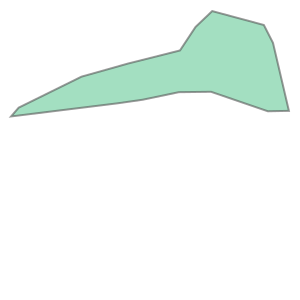

In [12]:
roi_file = ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/alex_single_planes/ROI for automated cell counting hm2asyn/#7_SN_wtOld/#7_SN_wt_s1_sfr2.roi')

roi_outline_coords_crop_corrected = []

for coords in roi_file.coordinates():
    corrected_row_idx = coords[1] - lower_row_idx
    corrected_column_idx = coords[0] - lower_column_idx
    roi_outline_coords_crop_corrected.append([corrected_row_idx, corrected_column_idx])
    
roi_outline_coords_crop_corrected = np.asarray(roi_outline_coords_crop_corrected)

substantia_nigra = Polygon(roi_outline_coords_crop_corrected)
substantia_nigra

In [19]:

cellpose_preds

['0000_cropped.png_class1.tif',
 '0001_cropped.png_class1.tif',
 '0002_cropped.png_class1.tif',
 '0003_cropped.png_class1.tif',
 '0004_cropped.png_class1.tif',
 '0005_cropped.png_class1.tif',
 '0006_cropped.png_class1.tif',
 '0007_cropped.png_class1.tif']

In [25]:
path = '/home/ds/Retune/3d_cell_counting/cropped_cellpose_preds/'

cellpose_preds = os.listdir(path)
cellpose_preds.sort()

final_preds_to_stack = []

for single_plane in cellpose_preds:

    cellpose_preds = plt.imread(path + single_plane)

    unique_values = np.unique(cellpose_preds)
    roi_ids = np.delete(unique_values, [0])

    positions_relative_to_reference = []

    for roi_id in roi_ids:
        temp_array = np.zeros((cellpose_preds.shape[0], cellpose_preds.shape[1]), dtype='uint8')
        temp_array[np.where(cellpose_preds == roi_id)] = 1
        temp_contours = measure.find_contours(temp_array, level = 0)[0]
        roi = Polygon(temp_contours)
        rel_position = get_relative_position(roi, substantia_nigra)
        positions_relative_to_reference.append((roi_id, rel_position))

    rois_to_exclude = [elem[0] for elem in positions_relative_to_reference if elem[1] != 'within']

    binarized_pred_after_exclusion = cellpose_preds.copy()

    for roi_id in rois_to_exclude:
        binarized_pred_after_exclusion[np.where(binarized_pred_after_exclusion == roi_id)] = 0


    binarized_pred_after_exclusion[np.where(binarized_pred_after_exclusion > 0)] = 255
    binarized_pred_after_exclusion = binarized_pred_after_exclusion.astype('uint8')

    n_rois_after_binarization = len(measure.find_contours(binarized_pred_after_exclusion, level=0))
    if n_rois_after_binarization != (len(positions_relative_to_reference) - len(rois_to_exclude)):
        print('Merging error for image: {}'.format(single_plane))
        print('Difference of {} cells'.format(str((len(positions_relative_to_reference) - len(rois_to_exclude)) - n_rois_after_binarization)))
        
    else:
        pass
    
    final_preds_to_stack.append(binarized_pred_after_exclusion)

Merging error for image: 0000_cropped.png_class1.tif
Difference of 1 cells
Merging error for image: 0001_cropped.png_class1.tif
Difference of 1 cells
Merging error for image: 0002_cropped.png_class1.tif
Difference of 6 cells
Merging error for image: 0003_cropped.png_class1.tif
Difference of 2 cells
Merging error for image: 0004_cropped.png_class1.tif
Difference of 2 cells


In [23]:
preds_in_3d = np.array(final_preds_to_stack)

labels_out_preds_in_3d, N_cc_preds_in_3d = cc3d.connected_components(preds_in_3d, return_N=True)

for cc_id in range(1,N_cc_preds_in_3d + 1):
    planes_with_cc_id = np.unique(np.where(labels_out_preds_in_3d == cc_id)[0])
    if planes_with_cc_id.shape[0] < 2:
        labels_out_preds_in_3d[np.where(labels_out_preds_in_3d == cc_id)] = 0

corrected_labels_out_preds_in_3d, corrected_N_cc_preds_in_3d = cc3d.connected_components(labels_out_preds_in_3d, return_N=True)
corrected_N_cc_preds_in_3d

63

In [ ]:
N_cc_preds_in_3d

In [ ]:
cc_id = 2

In [ ]:
planes_with_cc_id.shape[0]

In [ ]:
np.unique(labels_out_preds_in_3d)

In [ ]:
corrected_labels_out_preds_in_3d, corrected_N_cc_preds_in_3d = cc3d.connected_components(labels_out_preds_in_3d, return_N=True)

In [ ]:
corrected_N_cc_preds_in_3d

In [ ]:
np.unique(corrected_labels_out_preds_in_3d)

In [ ]:
plt.figure(figsize=(20,20))

plt.imshow(binarized_pred_after_exclusion)
plt.plot(substantia_nigra.exterior.coords.xy[1], substantia_nigra.exterior.coords.xy[0], color='black')
plt.show()


In [ ]:
roi_outline_coords_crop_corrected

In [ ]:
SN = Polygon(roi_outline_coords_crop_corrected)

In [ ]:
ROI = np.asarray([[1300, 1350], [1400, 1350], [1400, 1200], [1300, 1200]])

In [ ]:
cell = Polygon(ROI)

In [ ]:

empty_array = np.zeros((7595, 4625), dtype=np.uint8)
rr, cc = draw.polygon(roi_outline_coords_crop_corrected[:, 0], roi_outline_coords_crop_corrected[:, 1])
empty_array[rr, cc] = 1


In [ ]:
SN.exterior.coords.xy



In [ ]:
np.where(empty_array == 1)[0].shape

In [ ]:


contours = measure.find_contours(empty_array, level=0)

plt.imshow(empty_array)
plt.plot(contours[0][:, 1], contours[0][:, 0], color='red')

plt.ylim(1475, 1450)
plt.xlim(1500, 1525)
plt.show()

In [ ]:
SN.within(SN2)

In [ ]:
SN.contains(SN2)

In [ ]:
SN.intersection(SN2).area

In [ ]:
SN == SN2

In [ ]:
SN.area

In [ ]:
SN2 = Polygon(np.column_stack((contours[0][:, 0], contours[0][:, 1])))


In [ ]:
contours

In [ ]:
contours[0][:, 1]

In [ ]:
plt.plot(contours[0][:, 1], contours[0][:, 0], color='red')

In [ ]:
plt.imshow(mask)

In [ ]:
binarized_rois_after_exclusion

In [ ]:
binarized_rois_after_exclusion.astype('uint8')



In [ ]:
np.unique(cellpose_preds).shape

In [ ]:
measure.find_contours(

In [ ]:
cellposed_rois_after_exclusion = cellpose_preds.copy()


binarized_rois_after_exclusion = cellpose_preds.copy()
binarized_rois_after_exclusion[np.where(binarized_rois_after_exclusion > 0)] = 255

In [ ]:
cellposed_contours = measure.find_contours(cellposed_rois_after_exclusion, level=0)
len(cellposed_contours)

In [ ]:
binarized_contours = measure.find_contours(binarized_rois_after_exclusion, level=0)
len(binarized_contours)

In [ ]:
roi.touches(substantia_nigra)

In [ ]:
def meets_exclusion_criteria(cell, roi):
    

In [ ]:
plt.imshow(cellpose_preds)

In [ ]:
contours = measure.find_contours(cellpose_preds, level = 0)

len(contours)

In [ ]:
cellpose_preds.shape

In [ ]:
test = np.zeros((7588, 4606), dtype=np.uint8)
test[np.where(cellpose_preds==1)] = 1

plt.imshow(test)
plt.plot(contours[0][:, 1], contours[0][:, 0], c='red')

plt.ylim(3400, 3250)
plt.xlim(1750, 1900)


In [ ]:
plt.plot(contours[0][:, 0], contours[0][:, 1], c='red')

In [ ]:
np.where(cellpose_preds

In [ ]:
contours = measure.find_contours(empty_array, level=0)

plt.imshow(empty_array)
plt.plot(contours[0][:, 1], contours[0][:, 0], color='red')

plt.ylim(1475, 1450)
plt.xlim(1500, 1525)
plt.show()

In [ ]:
SN.contains(cell)

In [ ]:
SN.intersects(cell)

In [ ]:
list(SN.exterior.coords)

In [ ]:
SN_roi = ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/alex_single_planes/ROI for automated cell counting hm2asyn/#7_SN_wtOld/#7_SN_wt_s1_sfr2.roi')

In [ ]:
coords = SN_roi.coordinates()
coords_new = []
for elem in coords:
    new_column_index = elem[0] - lower_column_idx
    new_row_index = elem[1] - lower_row_idx
    coords_new.append([new_row_index, new_column_index])
    

In [ ]:
np.asarray(coords_new)[:, 0]

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(SN_cropped[:, :, 0])
plt.plot(np.asarray(coords_new)[:, 1], np.asarray(coords_new)[:, 0], c='red')
plt.plot([1350, 1350, 1200, 1200], [1300, 1400, 1400, 1300], c='black')

plt.ylim(1000, 1500)
plt.xlim(1100, 1400)
plt.show()

In [ ]:
ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/alex_single_planes/SN_in_full_size_image.roi')

In [ ]:
from PIL import Image

In [ ]:
SN_fullsize = plt.imread('/mnt/c/Users/dsege/TEMP/alex_single_planes/0000_000.png')

In [ ]:
SN_fullsize.shape

In [ ]:
SN_cropped = SN_fullsize[lower_row_idx:upper_row_idx, lower_column_idx:upper_column_idx]

In [ ]:
plt.imshow(SN_cropped)

In [ ]:
SN_cropped = SN_cropped.astype('uint8')

In [ ]:
SN_cropped = SN_cropped * 255

In [ ]:
SN_cropped.s

In [ ]:
plt.imshow(SN_cropped[:, :, 0])

In [ ]:
im = Image.fromarray(SN_cropped[:, :, 0])
im.save('/mnt/c/Users/dsege/TEMP/alex_single_planes/0000_000_cropped1.png')

In [ ]:
SN_roi_full_size = ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/alex_single_planes/SN_in_full_size_image.roi')
SN_roi_cropped = ImagejRoi.fromfile('/mnt/c/Users/dsege/TEMP/alex_single_planes/SN_in_cropped_image.roi')

In [ ]:
SN_roi_cropped.coordinates()

In [ ]:
SN_roi_full_size.coordinates().max()

In [ ]:
diff = SN_roi_full_size.coordinates() - SN_roi_cropped.coordinates()

In [ ]:
np.unique(diff)

In [ ]:
lower_row_idx

In [ ]:
lower_column_idx

In [ ]:
import os

os.listdir('/mnt/c/Users/dsege/TEMP/alex_single_planes/ROI for automated cell counting hm2asyn/')

In [ ]:
plane = stack[0].copy()

In [ ]:
plane = plane / 4095

In [ ]:
plt.imshow(plane)

In [ ]:
from roifile import ImagejRoi

In [ ]:
SN_roi.coordinates()

In [ ]:
SN_mask = np.asarray(SN_roi)

In [ ]:
SN_mask

In [ ]:
stack[0][:, :, 0].max()